<a href="https://www.kaggle.com/code/pumpernickel/container-throughput-forcast?scriptVersionId=98380696" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Container forcast using raindom forest model

In this project, we aims the build a prediction model for container throughput in Thailand port. 

We first load all the data collected throughout year 2001-2021. This included inbound and outbound container throughput. As for the features, we use features as follows

- Consumer price index
- Export value
- Import value
- GDP constant
- Inflation rate
- Interest rate
- Manufacture product index
- Population
- Unemployment rate
- USD to THB conversion rate

Resources:

[Feature selection for random forest](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py)

[Random forest regression model](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html?highlight=random%20forest%20regressor#sklearn.ensemble.RandomForestRegressor)

[Randomized search cross validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pydot
from PIL import Image


# Loading label for model prediction

First, we read inbound and outbound throughput from file and convert month data to number (0-12)

In [2]:
month_to_int = {'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 
'June':6, 'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12}


labels_df = pd.read_csv("../input/thai-container-throughput/container_throughput_label.csv")
labels_df['month'] = labels_df['month'].map(lambda x: month_to_int[x])

labels_df.head()


,year,month,inbound,outbound
0,2001,1,91751,82123
1,2001,2,83475,83014
2,2001,3,95149,95933
3,2001,4,86302,91967
4,2001,5,96431,101828


# Load features for model prediction

Similar to inbound and outbound value, we load all features and convert month to number

In [3]:
features_df = pd.read_csv("../input/thai-container-throughput/features.csv")
features_df = features_df.drop('id', axis=1)


features_df['month'] = features_df['month'].map(lambda x: month_to_int[x])
features_df = features_df.interpolate(axis=0)

features_df.head()

,year,month,export_value,GDP_constant,import_value,inflation_percentage_change,interest_rate,manufac_prod_index,population,unemployment_rate,exchange_rate,consumer_price_index
0,2001,1,279973.0,459359.0,255061.0,0.72,2.5,52.47,62308887.0,5.73,43.12,68.8
1,2001,2,279973.0,459359.0,255061.0,0.44,2.0,53.02,62308887.0,4.25,42.64,69.1
2,2001,3,279973.0,459359.0,255061.0,0.00,2.0,52.18,62308887.0,4.04,43.90,69.1
3,2001,4,283056.0,442241.0,255379.0,0.72,2.0,51.29,62308887.0,4.06,45.46,69.6
4,2001,5,283056.0,442241.0,255379.0,0.29,2.0,52.51,62308887.0,4.24,45.48,69.8


# Feature exploration

In this section, heatmap chart is created to see a correlation between each feature. As a result, it looks like export_value, GDP_constant, import_value, manufac_prod_index, population, and consumer_price_index are highly correlate to each other.

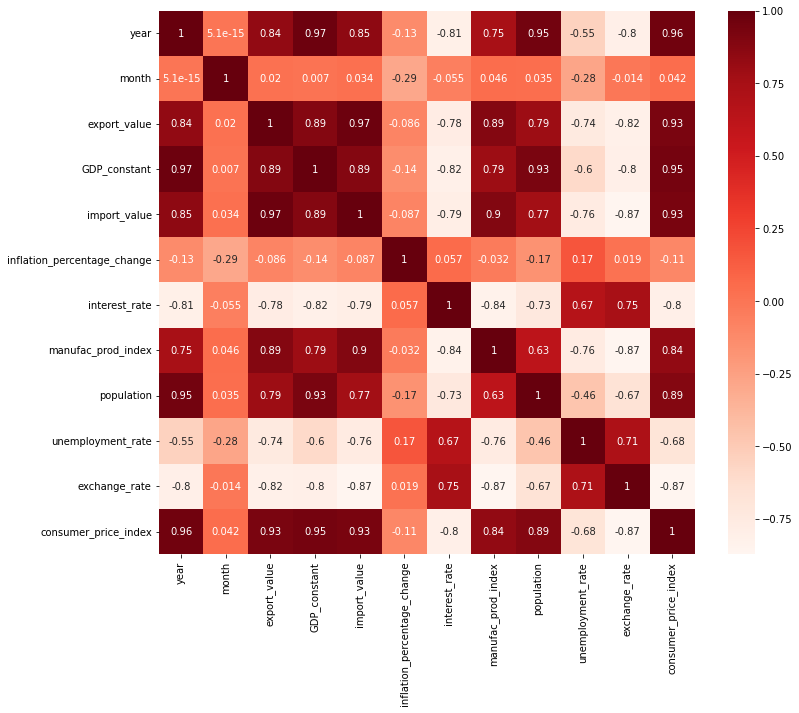

In [4]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = features_df.corr()
cor_map = sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [5]:
# Store correlation map to file
fig = cor_map.get_figure()
fig.savefig("cor_map.png") 

## Generate Training and Testing set

In this section, we will generate a training set and testing set for performing model training in the next section. The data will be split into 25% test set and 75% training set

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.tree import export_graphviz
from sklearn.inspection import permutation_importance


In [7]:
# Convert pandas dataframe to numpy array
feature_list = list(features_df.columns)
features = np.array(features_df)
labels = np.array(labels_df.drop(['year','month'], axis=1))
# Split data into training and testing set with 25% of test set
train_features, test_features, train_labels, test_labels = train_test_split(features, 
                                                            labels, test_size=0.25, random_state=42)


# Create Random forest model

In this section, a random forest model is created and parameter optimization is performed to find the best suitable parameter for the model

In [8]:
# Create set of parameters to perform parameter optimization
# n_estimators = [int(x) for x in np.linspace(10000, 50000, num=3)]
n_estimators = [900]
max_features = ['log2', 'sqrt', None]
max_depth = [int(x) for x in np.linspace(1, 100, num = 5)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_state = [int(x) for x in np.linspace(0, 50, num=5)]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'random_state': random_state}

print("Set of parameter optimization: \n")
for key, val in random_grid.items():
    print(f"{key}: {val}")

Set of parameter optimization: 

n_estimators: [900]
max_features: ['log2', 'sqrt', None]
max_depth: [1, 25, 50, 75, 100, None]
min_samples_split: [2, 5, 10]
min_samples_leaf: [1, 2, 4]
bootstrap: [True, False]
random_state: [0, 12, 25, 37, 50]


## Train model

In [9]:
start_time = time.time()
# Random search of parameters, using 3 fold cross validation, 
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, 
                            cv = 3, scoring = 'neg_mean_absolute_error', verbose=1, 
                            random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(train_features, train_labels)
elapsed_time = time.time() - start_time

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [10]:
print("\nDone. Parameters are")
for key, val in rf_random.best_params_.items(): 
    print(f"{key}: {val}")
print(f"\nElapsed time to find best parameter: {elapsed_time:.3f} seconds")


Done. Parameters are
random_state: 50
n_estimators: 900
min_samples_split: 5
min_samples_leaf: 2
max_features: log2
max_depth: 75
bootstrap: True

Elapsed time to find best parameter: 157.461 seconds


In [11]:
best_model = rf_random.best_estimator_
best_model.fit(train_features, train_labels)

RandomForestRegressor(max_depth=75, max_features='log2', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=900, random_state=50)

# Feature importance

After the model is tuned and fitted to the training set, this section will explore how the model see a significant in each features and then we will compare to the correlation map above

## Mean decrease in impurity

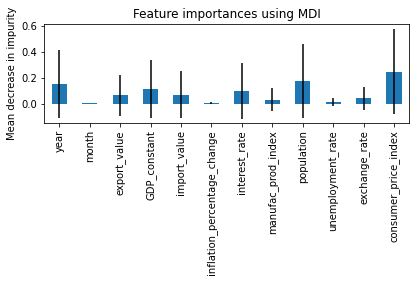

In [12]:
# Find feature importance variances for each tree in random forest

importances = best_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_model.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_list)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [13]:
fig.savefig('feature_importance_MDI.png')

## Permutation importance

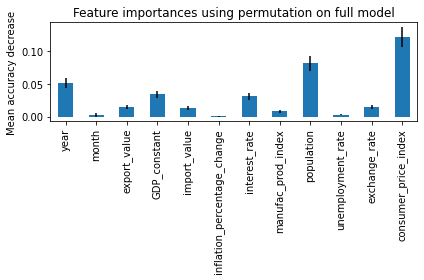

In [14]:
result = permutation_importance(
    best_model, test_features, test_labels, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=feature_list)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [15]:
fig.savefig('feature_importance_perm.png')

Conclusion: It seems like the model sees a similiar trends of features correlation. Feature such as consumer_price_index, population, GDP_constant, export_value, import_value, and manufac_prod_index are able to recognize as important by model while other features like interest_rate and exchange_rate which contradict the correlation to features mentioned before is consider important as well.

# Evaluataion of model

In this section, we would like to evaluate a forcasting result with feature selection and without it to see.

## Result without feature selection

In [16]:
predictions = best_model.predict(test_features)

In [17]:
# Print evaluation metric
print(f'Mean Absolute Error (MAE): {mean_absolute_error(test_labels, predictions)}')
print(f'Mean Squared Error (MSE): {mean_squared_error(test_labels, predictions)}')
print(f'Root Mean Squared Error (RMSE): {np.sqrt(mean_absolute_error(test_labels, predictions))}')
print(f'Mean Absolute Percentage Error (MAPE): {mean_absolute_percentage_error(test_labels, predictions)}')

Mean Absolute Error (MAE): 14946.331758365259
Mean Squared Error (MSE): 383561103.8205525
Root Mean Squared Error (RMSE): 122.2551911305416
Mean Absolute Percentage Error (MAPE): 0.06523886339257695


## Result with feature selection

In this experiment, inflation percentage changes and unemployment rate is exclude from model fitting to see the effect of feature selection

In [18]:
tr_features = train_features
te_features = test_features
tr_features = np.delete(tr_features, 5, 1)
tr_features = np.delete(tr_features, 9, 1)

te_features = np.delete(te_features, 5, 1)
te_features = np.delete(te_features, 9, 1)

feature_selected_model = RandomForestRegressor(max_depth=75, max_features='log2', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=900, random_state=50)
feature_selected_model.fit(tr_features, train_labels)
new_predictions = feature_selected_model.predict(te_features)

In [19]:
print(f'Mean Absolute Error (MAE): {mean_absolute_error(test_labels, new_predictions)}')
print(f'Mean Squared Error (MSE): {mean_squared_error(test_labels, new_predictions)}')
print(f'Root Mean Squared Error (RMSE): {np.sqrt(mean_absolute_error(test_labels, new_predictions))}')
print(f'Mean Absolute Percentage Error (MAPE): {mean_absolute_percentage_error(test_labels, new_predictions)}')

Mean Absolute Error (MAE): 15067.698140339076
Mean Squared Error (MSE): 383647873.24754477
Root Mean Squared Error (RMSE): 122.7505525052294
Mean Absolute Percentage Error (MAPE): 0.06599314159613774


### Conclusion

Despite, the insignificant of these 2 parameters. The random forest model still be able to make use of these parameters to fit it with the label.

# Examine prediction result

In [20]:
prediction_df = pd.DataFrame(data={'year': map(int, test_features.T[0]), 'month': map(int, test_features.T[1]), 
                                   'inbound': predictions.T[0], 'outbound': predictions.T[1],
                                  'real_inbound': test_labels.T[0], 'real_outbound': test_labels.T[1],
                                  'difference_inbound': abs(predictions.T[0] - test_labels.T[0]), 
                                   'difference_outbound': abs(predictions.T[1] - test_labels.T[1])})
prediction_df = prediction_df.sort_values(by=['year','month'])
prediction_df

,year,month,inbound,outbound,real_inbound,real_outbound,difference_inbound,difference_outbound
1,2001,7,99233.634345,100842.608686,96950,104299,2283.634345,3456.391314
8,2001,10,99984.016123,100714.550941,100494,96607,509.983877,4107.550941
28,2001,11,100663.770627,100333.285006,94651,97449,6012.770627,2884.285006
17,2002,4,109718.271155,109624.547953,101110,107746,8608.271155,1878.547953
46,2002,5,110442.929907,110477.288823,112976,119299,2533.070093,8821.711177
...,...,...,...,...,...,...,...,...
57,2019,5,328713.933912,337442.957861,316149,332296,12564.933912,5146.957861
12,2019,11,333258.968683,337339.661892,320016,322590,13242.968683,14749.661892
7,2020,8,300828.301640,309871.587530,281591,335236,19237.301640,25364.412470
25,2021,3,348623.382027,337324.561386,414725,382516,66101.617973,45191.438614


### Minimum difference between real inbound throughput and forcast inbound througput

In [21]:
prediction_df.loc[prediction_df['difference_inbound'] == prediction_df['difference_inbound'].min()]

,year,month,inbound,outbound,real_inbound,real_outbound,difference_inbound,difference_outbound
8,2001,10,99984.016123,100714.550941,100494,96607,509.983877,4107.550941


### Maximum difference between real inbound throughput and forcast inbound througput

In [22]:
prediction_df.loc[prediction_df['difference_inbound'] == prediction_df['difference_inbound'].max()]

,year,month,inbound,outbound,real_inbound,real_outbound,difference_inbound,difference_outbound
25,2021,3,348623.382027,337324.561386,414725,382516,66101.617973,45191.438614


### Minimum difference between real outbound throughput and forcast outbound througput

In [23]:
prediction_df.loc[prediction_df['difference_outbound'] == prediction_df['difference_outbound'].max()]

,year,month,inbound,outbound,real_inbound,real_outbound,difference_inbound,difference_outbound
42,2014,1,247166.566463,269543.819321,229511,220485,17655.566463,49058.819321


### Maximum difference between real outbound throughput and forcast outbound througput

In [24]:
prediction_df.loc[prediction_df['difference_outbound'] == prediction_df['difference_outbound'].max()]

,year,month,inbound,outbound,real_inbound,real_outbound,difference_inbound,difference_outbound
42,2014,1,247166.566463,269543.819321,229511,220485,17655.566463,49058.819321


In [25]:
prediction_df.to_csv('prediction.csv')

# Show a tree in Random forest

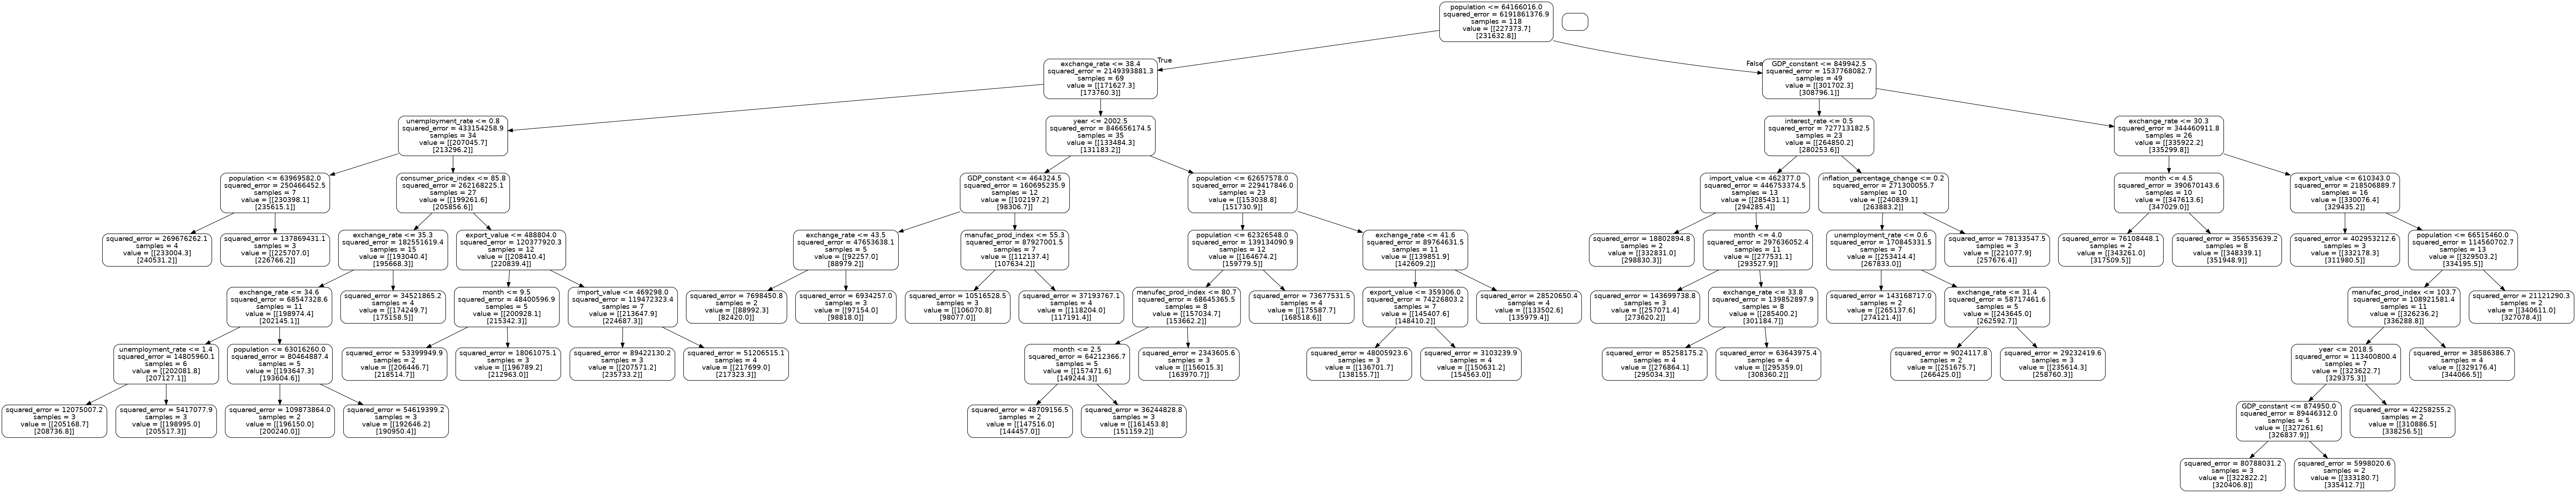

In [26]:
tree = best_model.estimators_[0]
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)

(graph, ) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')

Image.open('tree.png')
